# 3D TECHNOLOGIES
# REPORT: On Reducing Maintenance Cost
# Elaborated by: Sergio Nieto

## Objective

This document is a report on the work done by *The Data Science Team* building a predictive model using machine learning to predict the probability of a device failure. 


## Context

The data is about a fleet of devices transmitting daily aggregated telemetry
attributes.
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_columns', None)

In [2]:
np.random.seed(0)

In [3]:
# Problema inicial, no sabemos si es un csv...
# cat device_failure.csv | head no muestra problemas
# no sabemos el encoding, usamos latin-1 como primer intento

In [4]:
devices = pd.read_csv("device_failure.csv", encoding='Latin-1')

In [5]:
devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
# Buscamos el número de dispositivos

devices.device.nunique()

1169

In [7]:
# En un rango de fechas distintas

devices.date.nunique()

304

In [65]:
# Sin embargo, no todos tienen ese número de registros

# Veamos 2 ejemplos

devices[devices.device == "S1F01085"]["date"].value_counts()

2015-01-04    1
2015-01-03    1
2015-01-06    1
2015-01-02    1
2015-01-05    1
2015-01-01    1
Name: date, dtype: int64

In [9]:
devices[devices.device == "S1F01E6Y"]["date"].value_counts()

2015-02-15    1
2015-02-04    1
2015-02-03    1
2015-01-07    1
2015-01-09    1
2015-02-17    1
2015-02-06    1
2015-01-12    1
2015-01-06    1
2015-01-21    1
2015-01-24    1
2015-02-13    1
2015-01-29    1
2015-02-09    1
2015-01-20    1
2015-01-27    1
2015-01-25    1
2015-01-11    1
2015-02-07    1
2015-01-26    1
2015-01-10    1
2015-01-18    1
2015-01-19    1
2015-02-08    1
2015-01-14    1
2015-01-30    1
2015-02-11    1
2015-02-01    1
2015-01-28    1
2015-02-05    1
2015-02-10    1
2015-01-22    1
2015-02-02    1
2015-01-23    1
2015-01-02    1
2015-01-04    1
2015-01-03    1
2015-02-14    1
2015-01-31    1
2015-01-05    1
2015-01-13    1
2015-01-15    1
2015-01-01    1
2015-02-16    1
2015-01-08    1
2015-01-16    1
2015-02-12    1
2015-01-17    1
Name: date, dtype: int64

In [10]:
# Veamos la información del set de datos

devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [14]:
# Qué porcentaje de registros representan los fallos?

devices.failure.value_counts(normalize=True)

0    0.999149
1    0.000851
Name: failure, dtype: float64

In [10]:
devices["date"]=pd.to_datetime(devices["date"])

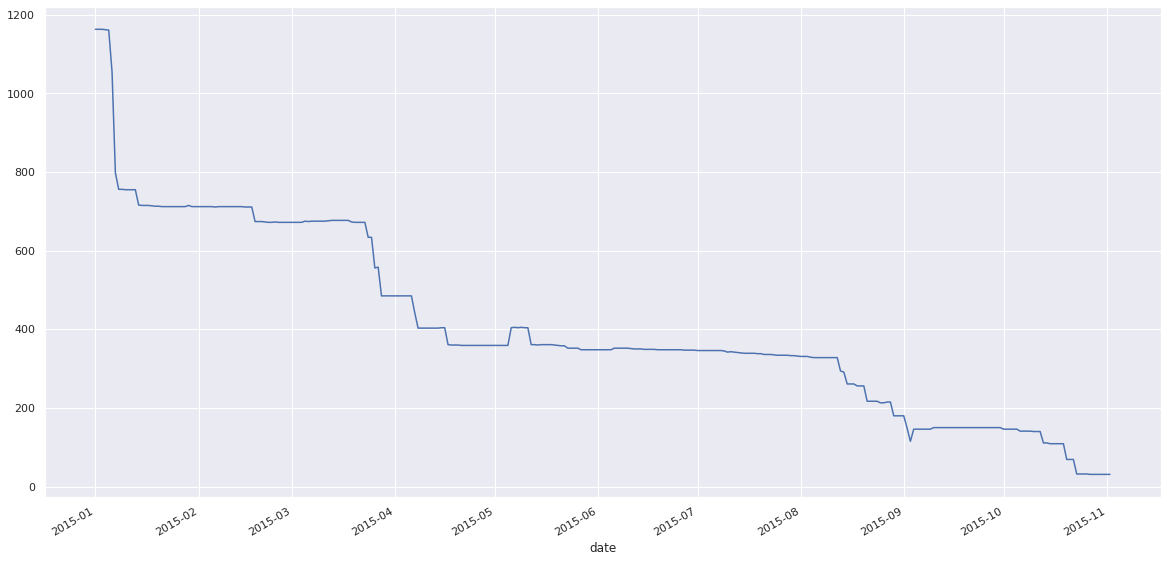

In [11]:
devices.groupby(["date"])["device"].nunique().plot()

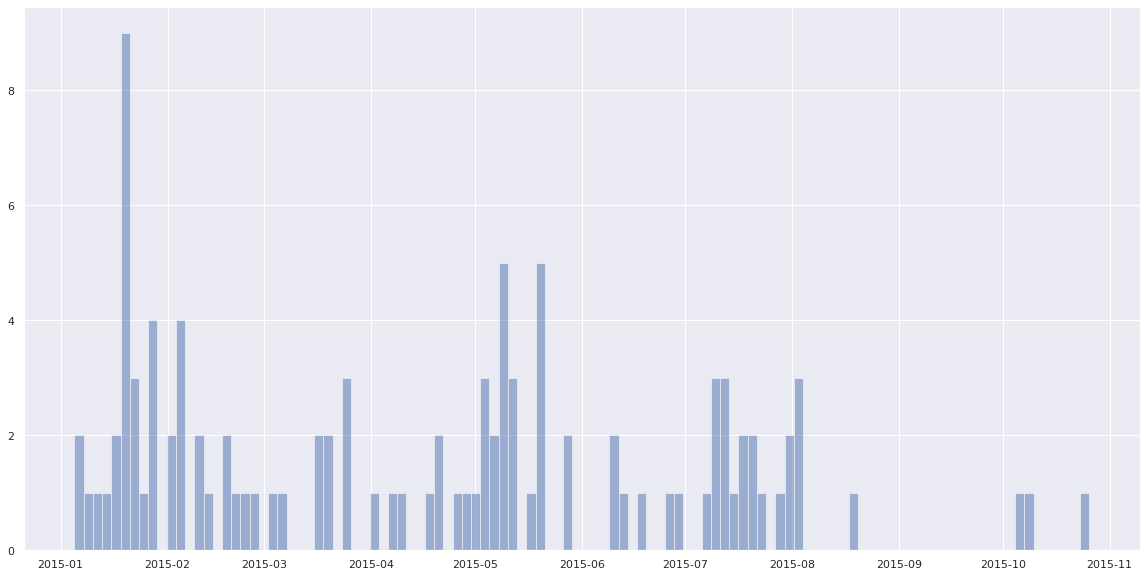

In [13]:
devices.query("(failure == 1)").date.hist(bins = 110, alpha = 0.5)

In [23]:
devices.groupby(["device"])["date"].count().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: date, dtype: float64

In [ ]:
# Del resumen vemos que no es uniforme el número fechas disponible por aparato.
# 

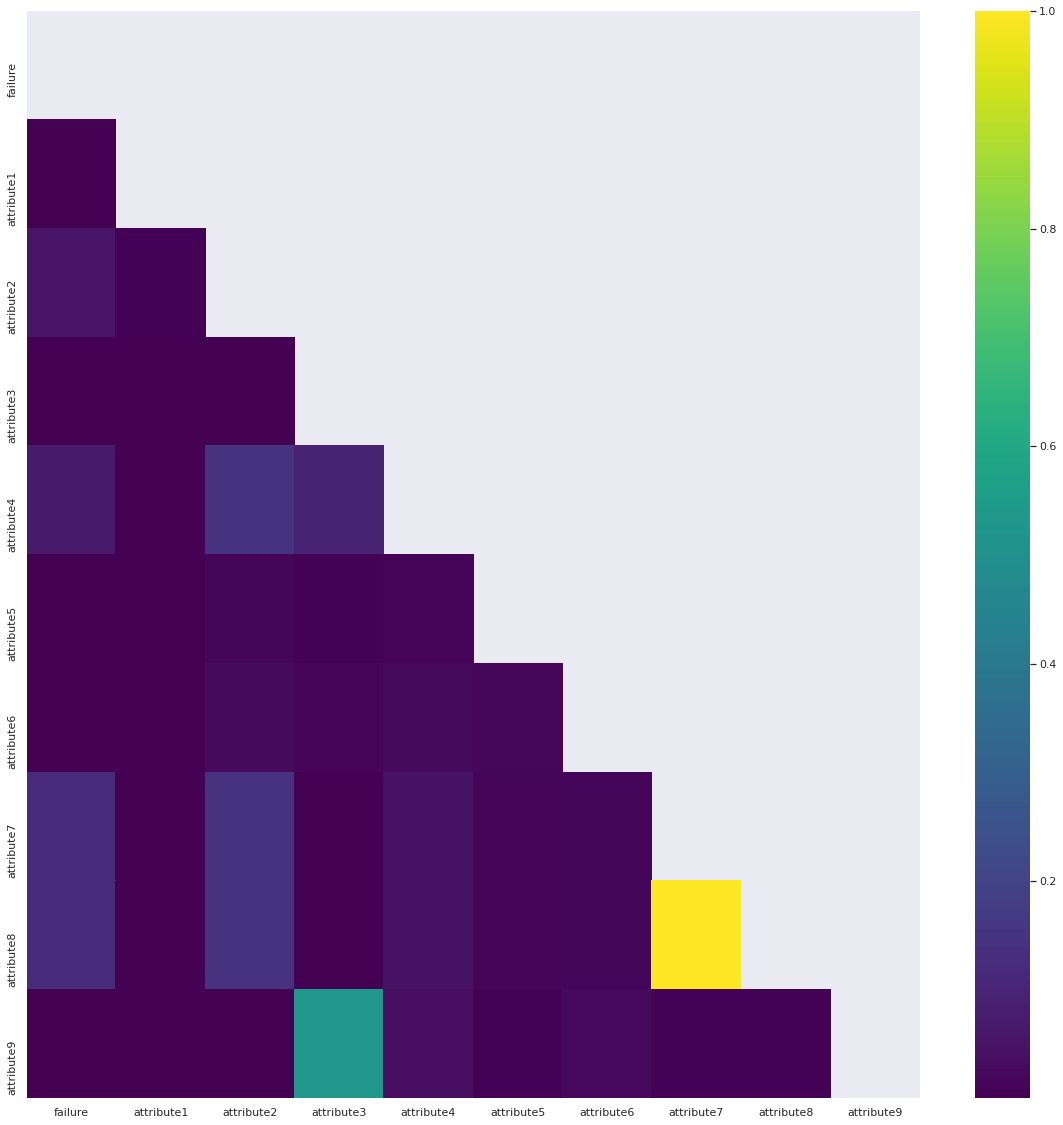

In [38]:
plt.figure(figsize=(20, 20))
corr = devices.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=False, cmap='viridis');

In [ ]:
## Al aprecer hay correlación 1 entre 2 variables, posiblemente repetidas attribute7 con attribute8

In [55]:
devices.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [40]:
devices.corr()['failure'].sort_values(ascending=False)

failure       1.000000
attribute8    0.119055
attribute7    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute6   -0.000550
attribute3   -0.000948
Name: failure, dtype: float64

In [46]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,1.00,0.00,0.05,-0.00,0.07,0.00,-0.00,0.12,0.12,0.00
attribute1,0.00,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
attribute2,0.05,-0.00,1.00,-0.00,0.15,-0.01,-0.03,0.14,0.14,-0.00
attribute3,-0.00,0.00,-0.00,1.00,0.10,-0.01,0.01,-0.00,-0.00,0.53
attribute4,0.07,0.00,0.15,0.10,1.00,-0.01,0.02,0.05,0.05,0.04
attribute5,0.00,-0.00,-0.01,-0.01,-0.01,1.00,-0.02,-0.01,-0.01,0.01
attribute6,-0.00,-0.00,-0.03,0.01,0.02,-0.02,1.00,-0.01,-0.01,0.02
attribute7,0.12,0.00,0.14,-0.00,0.05,-0.01,-0.01,1.00,1.00,0.01
attribute8,0.12,0.00,0.14,-0.00,0.05,-0.01,-0.01,1.00,1.00,0.01
attribute9,0.00,0.00,-0.00,0.53,0.04,0.01,0.02,0.01,0.01,1.00


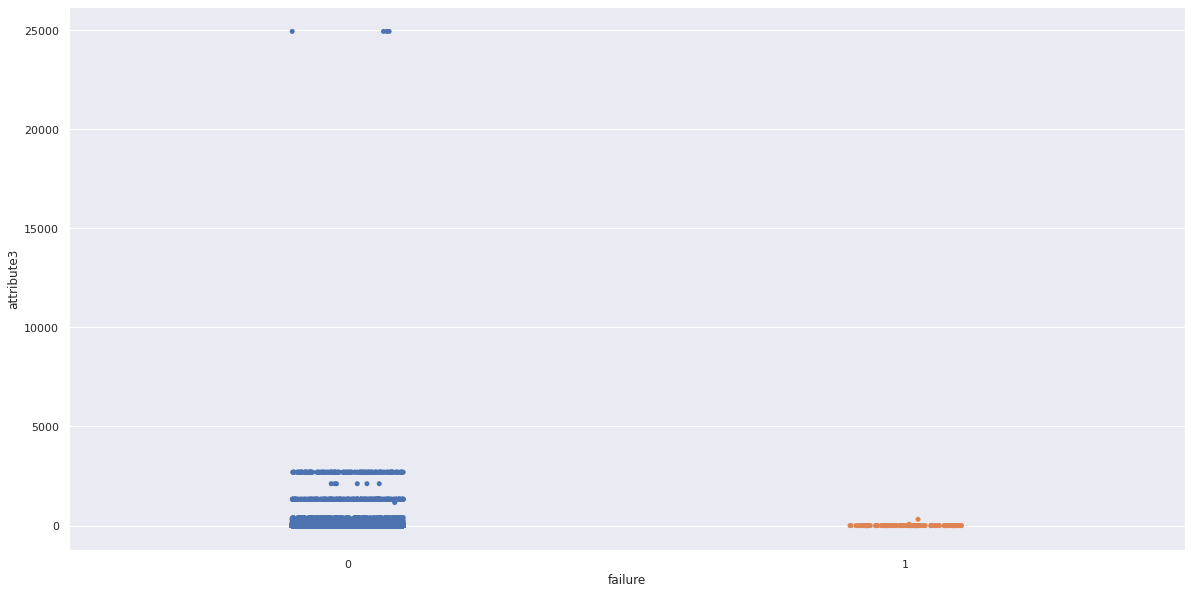

In [68]:
sns.stripplot(x="failure", y="attribute3", data=devices, jitter=True)
plt.show();

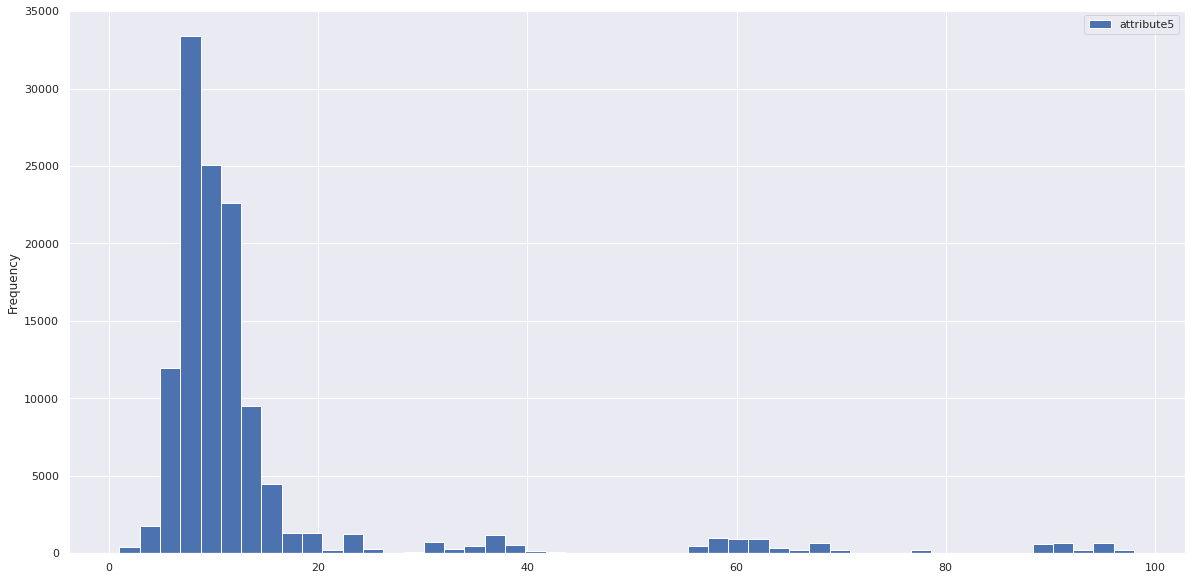

In [71]:
devices[["attribute5"]].plot(bins=50, kind="hist")

In [78]:
devices.attribute3.describe()

count    124494.000000
mean          9.940455
std         185.747321
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       24929.000000
Name: attribute3, dtype: float64

TypeError: unsupported operand type(s) for /: 'str' and 'int'

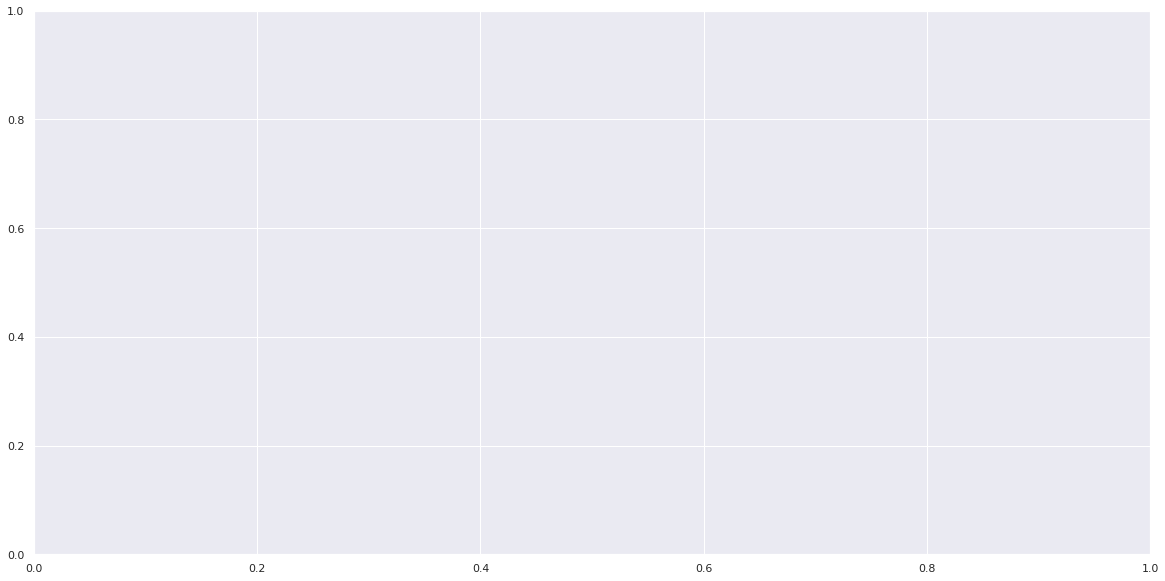

In [80]:
variable = "device"
ax = devices.boxplot(variable,by="date", grid=False)

plt.xlabel("Quincena")
plt.title("Value")
plt.suptitle("")

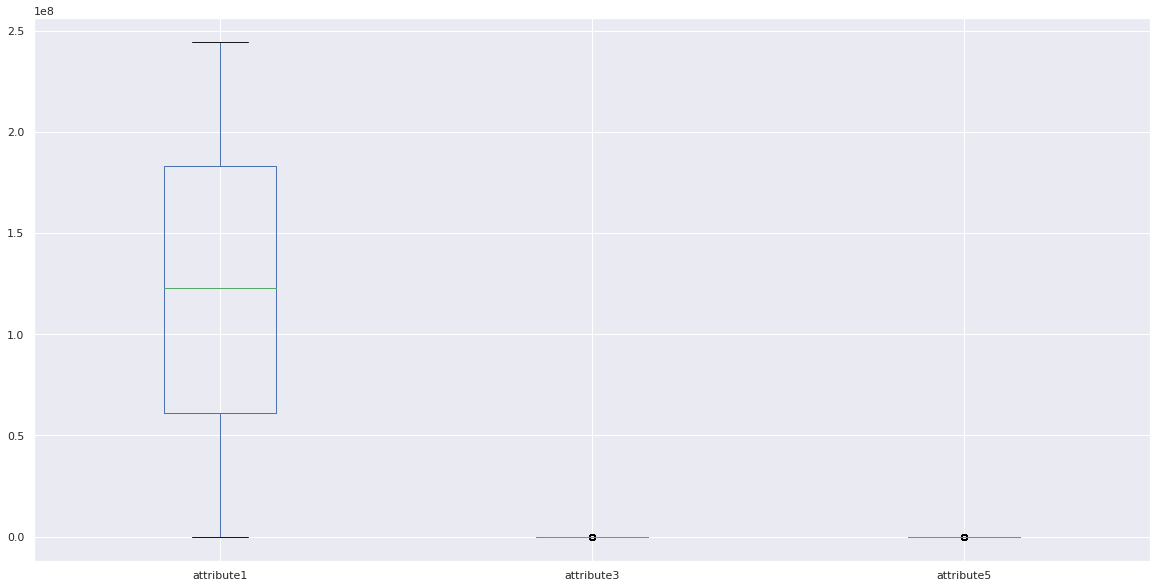

In [75]:
devices[['attribute2','attribute3','attribute5']].plot.box()

/home/sergio/miniconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:2264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


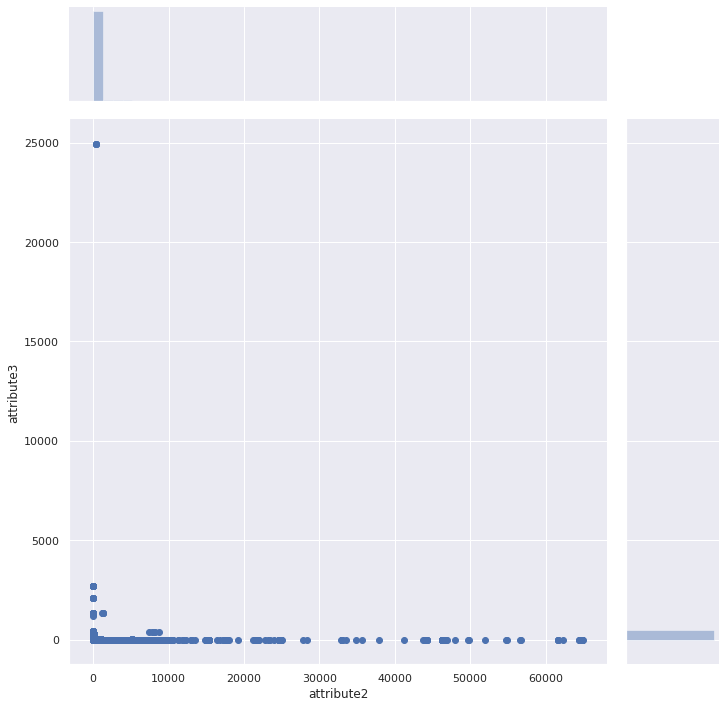

In [48]:
# A seaborn jointplot shows bivariate scatterplots and univariate histograms in the same figure
ax = sns.jointplot(x="attribute2", y="attribute3", data=devices, size=10)

# Pendientes

### 1. tiempo transcurrido hasta el fallo
### 2. establecer si hay un intervalo común, por ejemplo el 80% tiene 30 días de una serie de tiempo, igual los fallos
### 3. grafica tipo gant
### 4. si es posible concluir que no se hará un estudo de series sino de clasificación, mejor
### 5. Terminando lo anterior, iniciar feature selection
### 6. hacer el pipeline de transformación: estandarización, pca si es opción
### 7. prototipo sencillo con un árbol